In [1]:
# Install necessary libraries (if not installed)
!pip install timm torch torchvision

# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import os
import timm
from sklearn.model_selection import train_test_split
from collections import Counter


C:\Users\hrith\.conda\envs\env1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!pip install simple_image_download

In [3]:
from torch.utils.data import Dataset
from PIL import Image, UnidentifiedImageError
import os

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))  # Get class names
        self.image_paths = []
        self.labels = []

        for class_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)

                # Check if image is readable
                if self.is_valid_image(img_path):
                    self.image_paths.append(img_path)
                    self.labels.append(class_idx)
                else:
                    print(f"❌ Removing unreadable image: {img_path}")
                    os.remove(img_path)  # Delete unreadable image

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGBA")  # Convert to RGBA for PNG support
        image = image.convert("RGB")  # Convert RGBA to RGB

        if self.transform:
            image = self.transform(image)

        return image, label

    def is_valid_image(self, img_path):
        """Check if an image is readable."""
        try:
            with Image.open(img_path) as img:
                img.verify()  # Verify image integrity
            return True
        except (UnidentifiedImageError, IOError):
            return False


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for ViT
    transforms.RandomHorizontalFlip(),  # Data Augmentation
    transforms.RandomRotation(15),  # Random Rotation
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2)], p=0.5),  # Random Brightness
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize RGB (3 channels)
])


In [5]:
dataset_path = r"C:\Users\hrith\OneDrive\Desktop\EDL\dataset2_20250319T040147Z_001\dataset2"
full_dataset = CustomDataset(dataset_path, transform=transform)

# Get labels for stratified split
labels = [label for _, label in full_dataset]

# Stratified split
train_indices, val_indices = train_test_split(range(len(labels)), test_size=0.2, stratify=labels, random_state=42)

# Subset dataset
train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
val_dataset = torch.utils.data.Subset(full_dataset, val_indices)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Check class distribution
def count_classes(dataset):
    class_counts = Counter()
    for _, label in dataset:
        class_counts[label] += 1
    return class_counts

print("\n📊 Class Distribution:")
print("🔹 Train:", count_classes(train_dataset))
print("🔹 Validation:", count_classes(val_dataset))


📊 Class Distribution:
🔹 Train: Counter({0: 299, 1: 293, 4: 286, 2: 280, 5: 278, 3: 266, 6: 244})
🔹 Validation: Counter({0: 75, 1: 74, 4: 71, 2: 70, 5: 69, 3: 67, 6: 61})


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ViT model
model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=len(full_dataset.classes))
model.to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Learning rate = 0.0001

print("✅ Model Loaded & Ready for Training!")
print(f"🚀 Using {'GPU' if torch.cuda.is_available() else 'CPU'} for training.")


✅ Model Loaded & Ready for Training!
🚀 Using GPU for training.


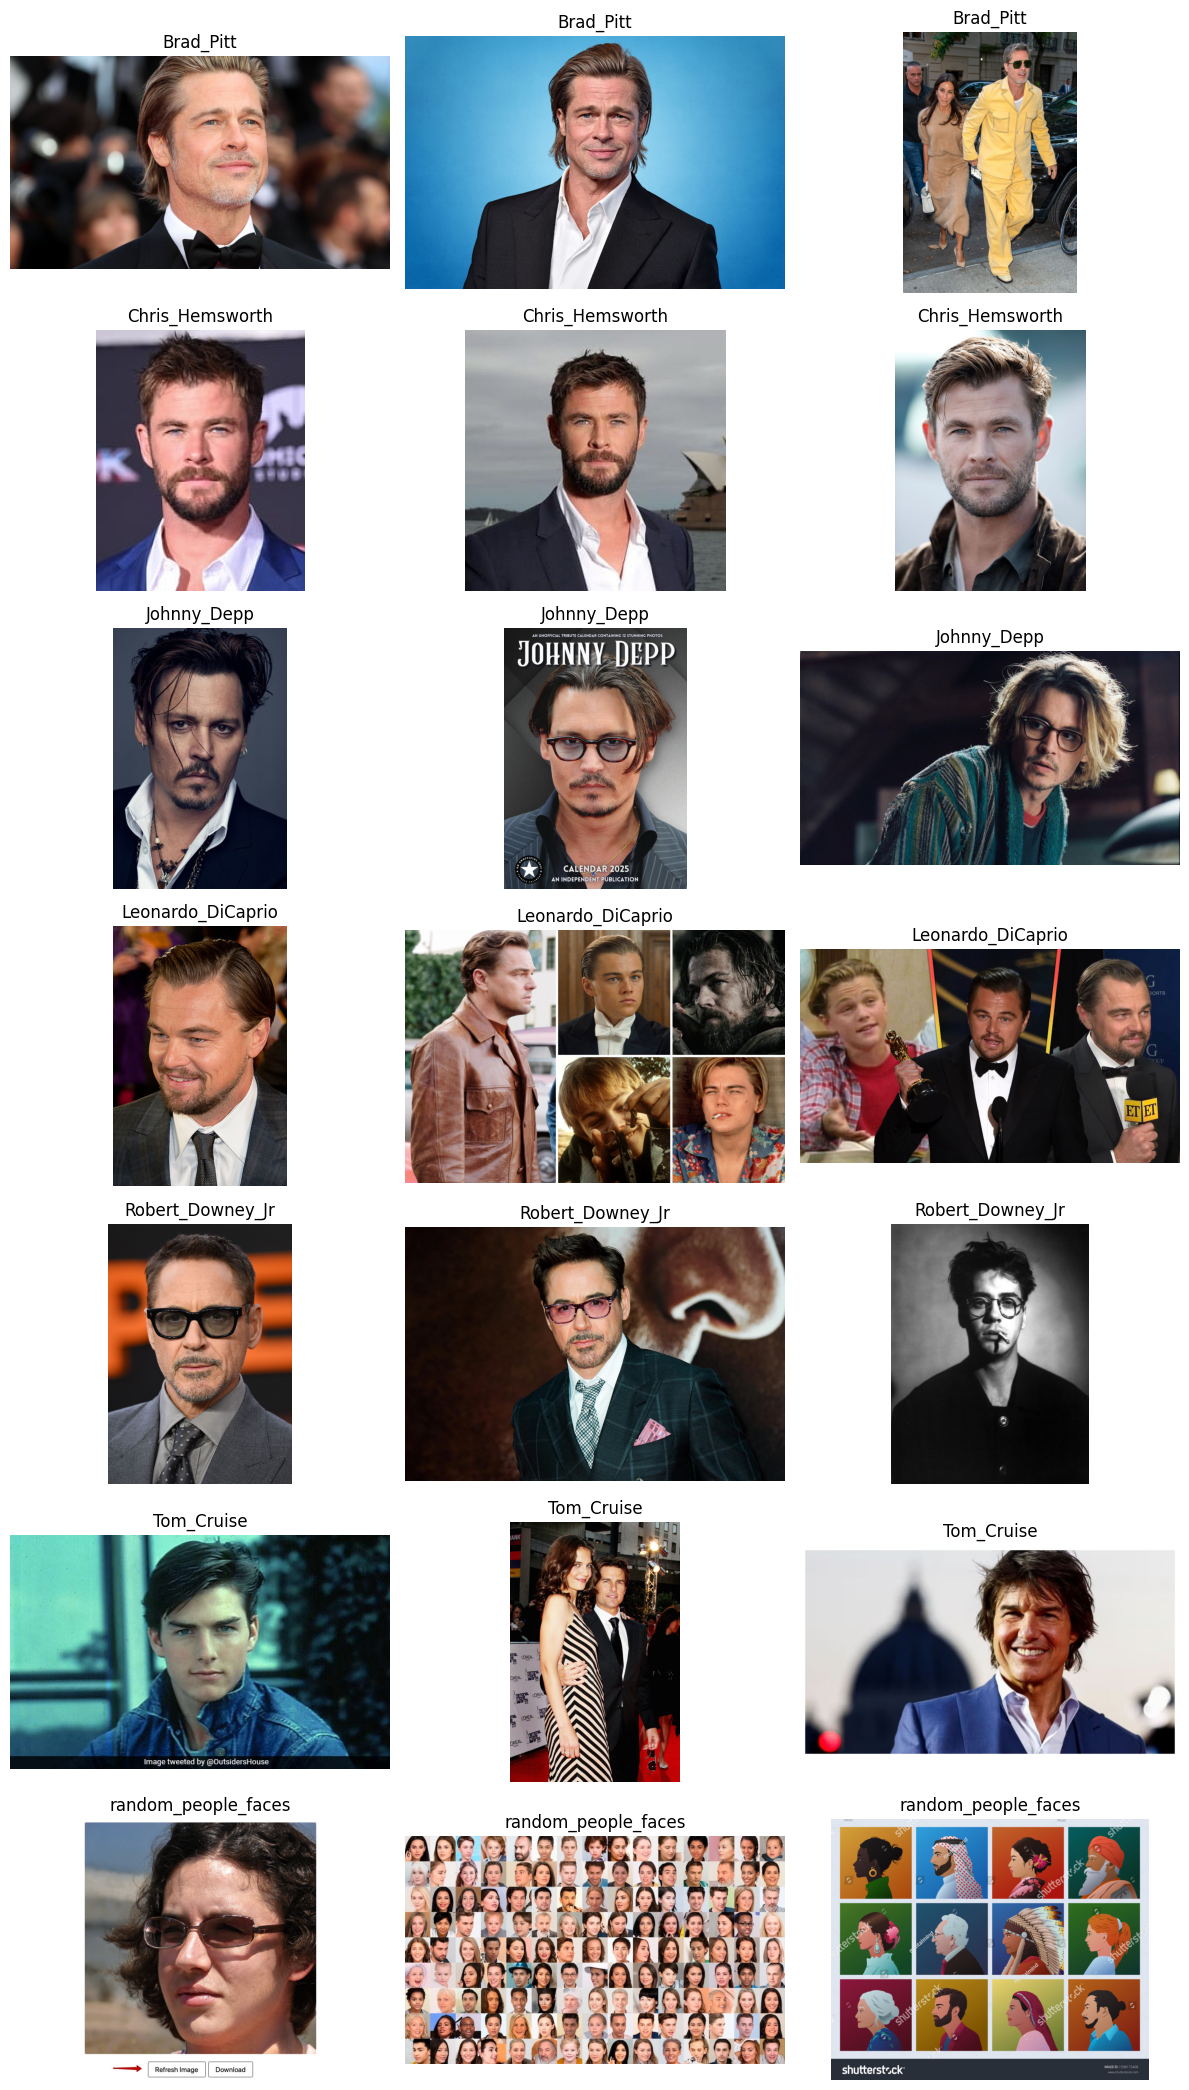

In [10]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# ✅ Define dataset path
dataset_path = r"C:\Users\hrith\OneDrive\Desktop\EDL\dataset2_20250319T040147Z_001\dataset2"

# ✅ Get class names (folders only)
class_names = [cls for cls in sorted(os.listdir(dataset_path)) if os.path.isdir(os.path.join(dataset_path, cls))]

# ✅ Define number of images per class
num_images_per_class = 3

# ✅ Set up figure size
plt.figure(figsize=(12, len(class_names) * 3))

# ✅ Loop through each class and display images
for class_idx, class_name in enumerate(class_names):
    class_folder = os.path.join(dataset_path, class_name)
    image_files = [img for img in os.listdir(class_folder) if img.lower().endswith(('png', 'jpg', 'jpeg'))]

    # ✅ Pick 3 random images (if available)
    selected_images = random.sample(image_files, min(num_images_per_class, len(image_files)))

    for img_idx, image_name in enumerate(selected_images):
        image_path = os.path.join(class_folder, image_name)
        image = Image.open(image_path).convert("RGB")  # Convert to RGB to avoid errors

        # ✅ Create subplot
        plt.subplot(len(class_names), num_images_per_class, class_idx * num_images_per_class + img_idx + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"{class_name}")

# ✅ Adjust layout and show images
plt.tight_layout()
plt.show()

Epoch [1/6] - Train Loss: 2.0078, Train Acc: 16.70% | Val Loss: 1.9195, Val Acc: 22.79%
✅ Model Saved!
Epoch [2/6] - Train Loss: 1.8604, Train Acc: 23.84% | Val Loss: 1.8163, Val Acc: 32.03%
✅ Model Saved!
Epoch [3/6] - Train Loss: 1.1685, Train Acc: 57.04% | Val Loss: 0.4987, Val Acc: 80.90%
✅ Model Saved!
Epoch [4/6] - Train Loss: 0.3245, Train Acc: 89.16% | Val Loss: 0.2258, Val Acc: 93.02%
✅ Model Saved!
Epoch [5/6] - Train Loss: 0.1083, Train Acc: 96.15% | Val Loss: 0.1733, Val Acc: 93.22%
✅ Model Saved!
Epoch [6/6] - Train Loss: 0.1316, Train Acc: 95.12% | Val Loss: 0.0735, Val Acc: 96.30%
✅ Model Saved!
🎉 Training Complete!


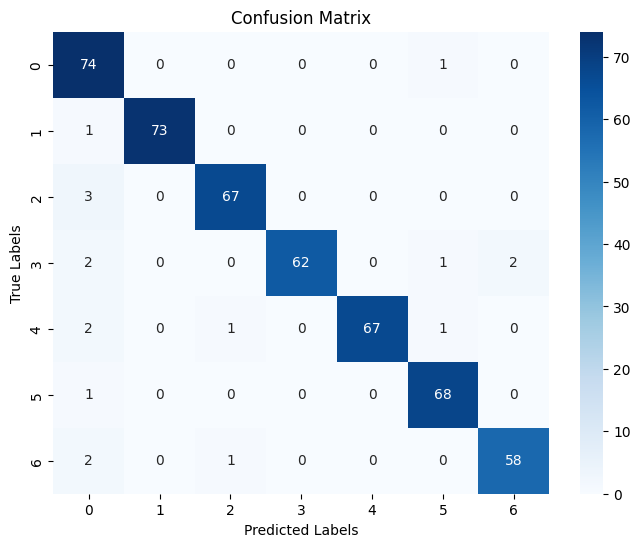

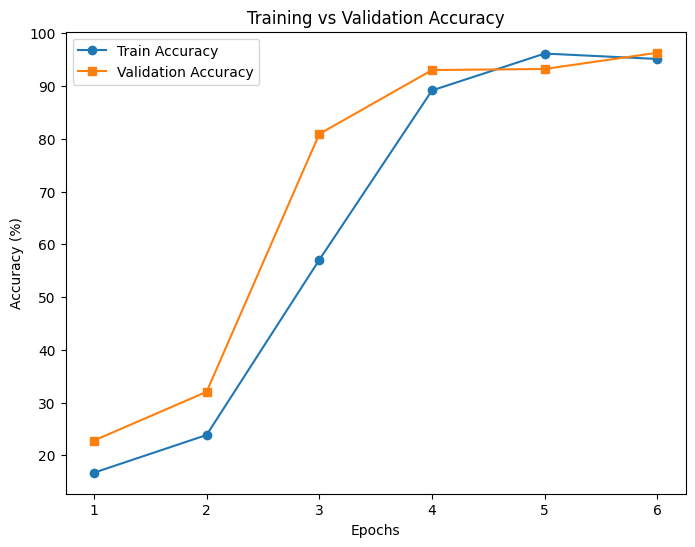

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import itertools

num_epochs = 6
best_val_loss = float('inf')

train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_acc_history.append(train_acc)

    # Validation Step
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    val_acc = 100 * correct / total
    val_loss /= len(val_loader)
    val_acc_history.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Save Best Model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(),r"C:\Users\hrith\OneDrive\Desktop\EDL\eddata\best_vit_model1.pth")
        print("✅ Model Saved!")

print("🎉 Training Complete!")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve (Only applicable for binary classification or multi-class with one-vs-all approach)
if len(set(all_labels)) == 2:
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

# Comparison of Training vs Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_acc_history, label="Train Accuracy", marker="o")
plt.plot(range(1, num_epochs + 1), val_acc_history, label="Validation Accuracy", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


In [22]:
class_names

['Brad_Pitt',
 'Chris_Hemsworth',
 'Johnny_Depp',
 'Leonardo_DiCaprio',
 'Robert_Downey_Jr',
 'Tom_Cruise',
 'random_people_faces']

Image: Brad Pitt_24.jpg | Predicted Class: Brad_Pitt


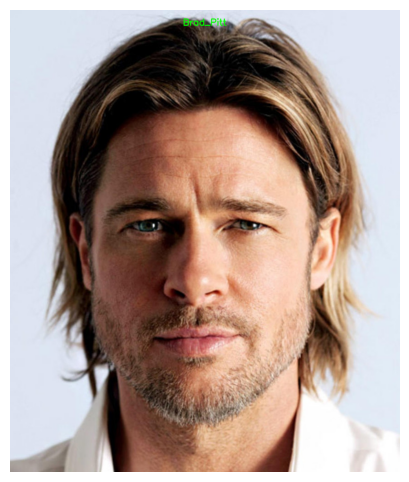

Image: Chris Hemsworth_4.jpg | Predicted Class: Chris_Hemsworth


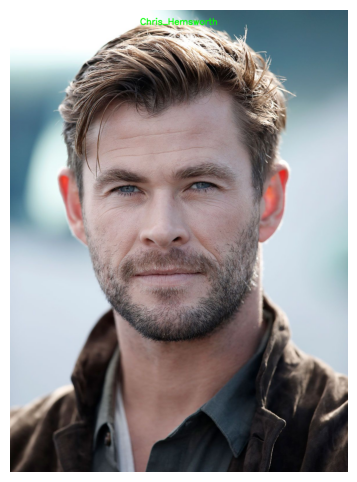

Image: Johnny Depp_8.jpg | Predicted Class: Johnny_Depp


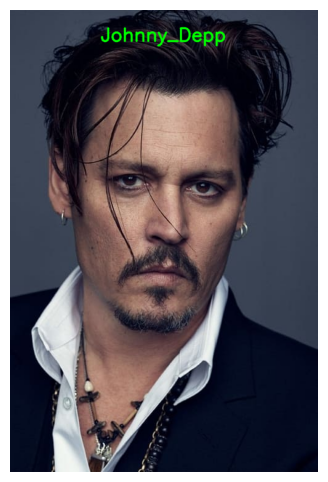

Image: Leonardo DiCaprio_205.jpg | Predicted Class: Leonardo_DiCaprio


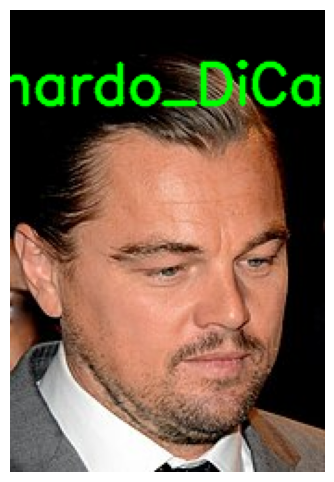

Image: random people faces_50.jpg | Predicted Class: random_people_faces


C:\Users\hrith\.conda\envs\env1\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


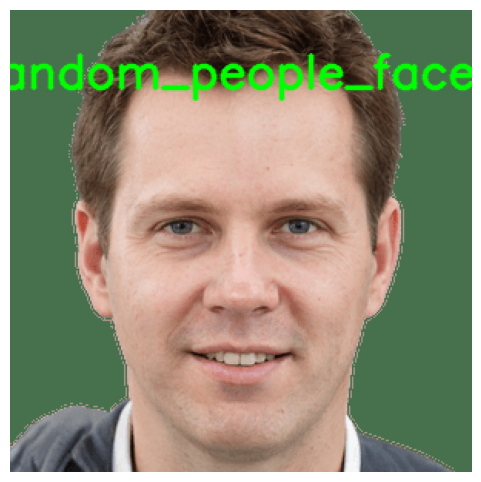

Image: Robert Downey Jr._18.jpg | Predicted Class: Robert_Downey_Jr


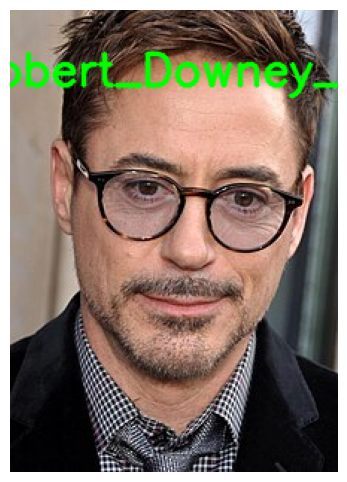

Image: Tom Cruise_59.jpg | Predicted Class: Tom_Cruise


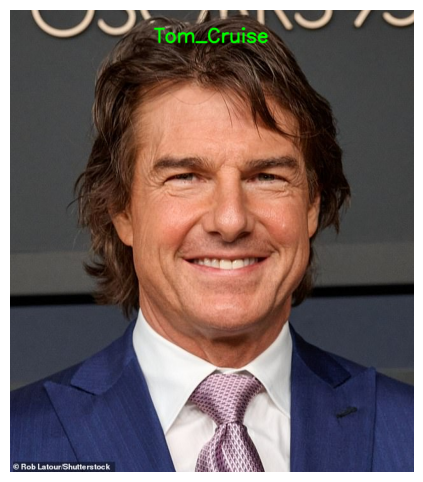

In [21]:
import os
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw, ImageFont

# ✅ Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Load the trained model
model.load_state_dict(torch.load(r"C:\Users\hrith\OneDrive\Desktop\EDL\eddata\best_vit_model1.pth"))
model.to(device)
model.eval()

# ✅ Define class names from dataset folders
dataset_path = r"C:\Users\hrith\OneDrive\Desktop\EDL\dataset2_20250319T040147Z_001\dataset2"
class_names = [cls for cls in sorted(os.listdir(dataset_path)) if os.path.isdir(os.path.join(dataset_path, cls))]

# ✅ Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Modify based on training normalization
])

# ✅ Path to the folder containing test images
test_folder = r"C:\Users\hrith\OneDrive\Desktop\EDL\image2"

# ✅ Collect images for prediction
image_files = [img for img in os.listdir(test_folder) if img.lower().endswith(('png', 'jpg', 'jpeg'))]

# ✅ Iterate through test images and predict
for image_name in image_files:
    image_path = os.path.join(test_folder, image_name)
    image = Image.open(image_path).convert("RGB")  # Convert to RGB
    
    # ✅ Transform the image
    transformed_image = transform(image).unsqueeze(0).to(device)

    # ✅ Perform prediction
    with torch.no_grad():
        output = model(transformed_image)
        _, predicted = torch.max(output, 1)

    predicted_index = predicted.item()
    
    # ✅ Ensure predicted index is valid before accessing `class_names`
    if 0 <= predicted_index < len(class_names):
        class_name = class_names[predicted_index]
    else:
        class_name = "Unknown Class"

    print(f"Image: {image_name} | Predicted Class: {class_name}")  # Print prediction

    # ✅ Convert to OpenCV format for text overlay
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # ✅ Define text properties
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_thickness = 2
    text_size = cv2.getTextSize(class_name, font, font_scale, font_thickness)[0]
    text_x = (image_cv.shape[1] - text_size[0]) // 2
    text_y = 50

    # ✅ Overlay text on image
    cv2.putText(image_cv, class_name, (text_x, text_y), font, font_scale, (0, 255, 0), font_thickness, cv2.LINE_AA)

    # ✅ Display image
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
